In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import os

C:\Program Files\Anaconda3\envs\carmi_thesis_3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import importlib
import plot, loaders
plot = importlib.reload(plot)
loaders = importlib.reload(loaders)

In [3]:
PGS_DIR = os.path.join("data", "pgs")
SAVE_FIG_DIR = "figure13"

# Gain Variance

## Longevity Model

In [4]:
longevity_data = loaders.load_longevity_data(pgs_col=os.path.join(PGS_DIR, "longevity_height"), convert_to_cm=True)
longevity_data.rename(columns={"PGS": "Height_PGS"}, inplace=True)
longevity_data.head(2)

const  Gender  Age  Height_PGS  Height
FID IID                                        
2   427    1.0       0   61    0.000028  157.48
    448    1.0       1   62    0.000028  177.80

#### Logenvity Height Model

In [5]:
height_model_covar = sm.OLS.from_formula("Height ~ 1 + Gender + Age", longevity_data).fit()
print("Covaraite model:", height_model_covar.rsquared)
longevity_data["Height_resid"] = height_model_covar.resid
height_model_pgs_res = sm.OLS.from_formula("Height_resid ~ 1 + Height_PGS", longevity_data).fit()
# print(height_model_pgs_res.summary())
print("PGS model:", height_model_pgs_res.rsquared)

Covaraite model: 0.6083835435619124
PGS model: 0.24301847295464685


## Prediction

In [7]:
longevity_so_50_height_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_random_50_height"), "Height_PGS")
longevity_so_50_height_pred = height_model_pgs_res.predict(sm.add_constant(longevity_so_50_height_pgs))
longevity_so_50_height_pred.head(3)

FID        IID 
1130_7342  SO00    0.953512
           SO01    2.792158
           SO02    1.256919
dtype: float64

## Compare to theoretical model

#### Sample increasing size families

In [8]:
def sample_subset(df, groupby_colname="FID"):
    res = {}
    max_fam_size = df.groupby(groupby_colname).size().iloc[0]
    for n in range(max_fam_size, 0, -1):
        df = df.groupby(groupby_colname).apply(lambda x: x.sample(n=n).reset_index("FID", drop=True))
        # reset_index() within each sample otherwise "FID" index multiplies and accumulates
        res[n] = df.copy()
    return res

In [63]:
longevity_so_pred = sample_subset(longevity_so_50_height_pred)

#### Calculate gain

In [51]:
def calculate_gain(dfs, groupby_colname="FID", greater_is_better=True):
    res = {}
    for n, df in dfs.items():
        df_gb = df.groupby(groupby_colname)
        if greater_is_better:
            gain = df_gb.max() - df_gb.mean()
        else:
            gain = df_gb.mean() - df_gb.min()
        gain = gain.agg(["mean", "sem", "std", "var"])
        gain["ci95"] = stats.norm.ppf(0.95) * gain["sem"]
        res[n] = gain
    res = pd.DataFrame.from_dict(res, orient="index")
    res.index.name = "n_sibs"
    return res

In [64]:
so_gain = calculate_gain(longevity_so_pred)
so_gain.sample(6)

mean       sem       std       var      ci95
n_sibs                                                  
25      4.096942  0.109068  1.090675  1.189573  0.179400
37      4.405666  0.102256  1.022565  1.045638  0.168197
27      4.155442  0.107860  1.078595  1.163367  0.177413
14      3.494685  0.101406  1.014061  1.028320  0.166798
17      3.686972  0.106222  1.062224  1.128320  0.174720
33      4.338821  0.104706  1.047059  1.096332  0.172226

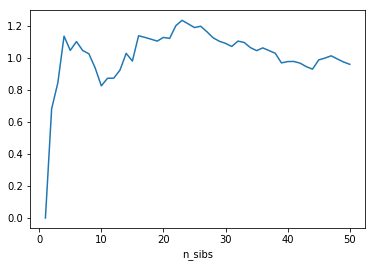

In [65]:
so_gain["var"].plot()

In [74]:
def multiple_var(n=100):
    res = []
    for j in range(n):
        sample = sample_subset(longevity_so_50_height_pred)
        sample_gain = calculate_gain(sample)
        sample_gain = sample_gain["var"]
        sample_gain = sample_gain.rename(j)
        res.append(sample_gain)
    res = pd.DataFrame(res)
    res.index.name = "draw"
    return res
gain_var = multiple_var()
gain_var.to_csv(r"C:\Studies\MSc\carmi_thesis\research\embryo_variance_5\figure13\data_4.txt")

In [70]:
gain_var = pd.read_clipboard()
gain_var = gain_var.set_index("n_sibs")["gain_var"]

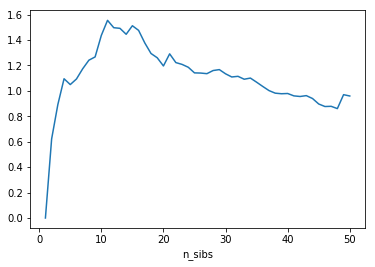

In [71]:
gain_var.plot()